# DLT Quick Start

**DLT** stands for `Damped Local Trend` model, which is an important model type in orbit package. In the model equation, there is a local trend term and a global trend term.

In this notebook we will show how to use Orbit DLT models with the US unemployment claims data and different gloabl trend options.

In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import orbit
from orbit.models.dlt import DLTMAP, DLTAggregated, DLTFull
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [2]:
orbit.__version__

'1.0.14dev'

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job) from Jan 2010 - June 2018.

This aim is to mimick the dataset from the paper [Predicting the Present with Bayesian Structural Time Series](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).
Note that dataset is transformed by natural log before fitting in order to have a multiplicative model.

In [3]:
# load data
df = load_iclaims()

df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [4]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [5]:
DATE_COL = 'week'
RESPONSE_COL = 'claims'

### Train / Test Split

In [6]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

In [7]:
train_df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


## DLT Model

**DLT** stands for Damped Local Trend model,

$$ y_{t}  = \hat{y}_t + \epsilon $$
$$\hat{y}_t=\mu_t + s_t + r_t $$
$$\mu_t=D(t) + l_{t-1} +  \theta{b_{t-1}}$$

with the update process as such 

$$g_t = D(t)$$
$$l_t = \rho_l(y_t - g_{t} - s_t - r_t) + (1-\rho_l)l_{t-1}$$
$$b_t=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)\theta{b_{t-1}}$$
$$s_{t+m} =  \rho_s(y_t - l_t - r_t) + (1-\rho_s)s_t$$
$$r_t =  \Sigma_{j}\beta_j x_{jt}$$

There are a few choices of $D(t)$ as a global trend, such as linear, log-linear and logistic. Another feature of DLT is the regression component $r_t$. This serves the purpose of nowcasting or forecasting when exogenous regressors are known such as events and holidays.  Without losing generality, assume

$$\beta_j ~\sim \mathtt{Normal}(\mu_j, \sigma_j)$$

where $\mu_j = 0$  and $\sigma_j = 1$ by default as a non-informative prior. There are more choices of priors for the regression component in the package.

In orbit, we have three different wrappers for DLT models, `DLTMAP`, `DLTAggregated` and  `DLTFull`

### DLTMAP

DLT model for MAP (Maximum a Posteriori) prediction

In [8]:
dlt = DLTMAP(response_col=RESPONSE_COL,
             date_col=DATE_COL,
             seasonality=52,
             seed=8888)

In [9]:
dlt.fit(df=train_df)

Initial log joint probability = 61.647
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       773.489     0.0671633       37.5144      0.6827      0.6827       24   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       784.941     0.0563466       29.0446           1           1       45   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       790.553     0.0323381       21.6499           1           1       67   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       792.122     0.0548548       27.0256      0.4955      0.4955       89   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.116    0.00919907       7.51184      0.3754      0.8815      111   
    Iter      log prob        ||dx||      ||grad||       alpha    

In [10]:
predicted_df = dlt.predict(df=test_df)

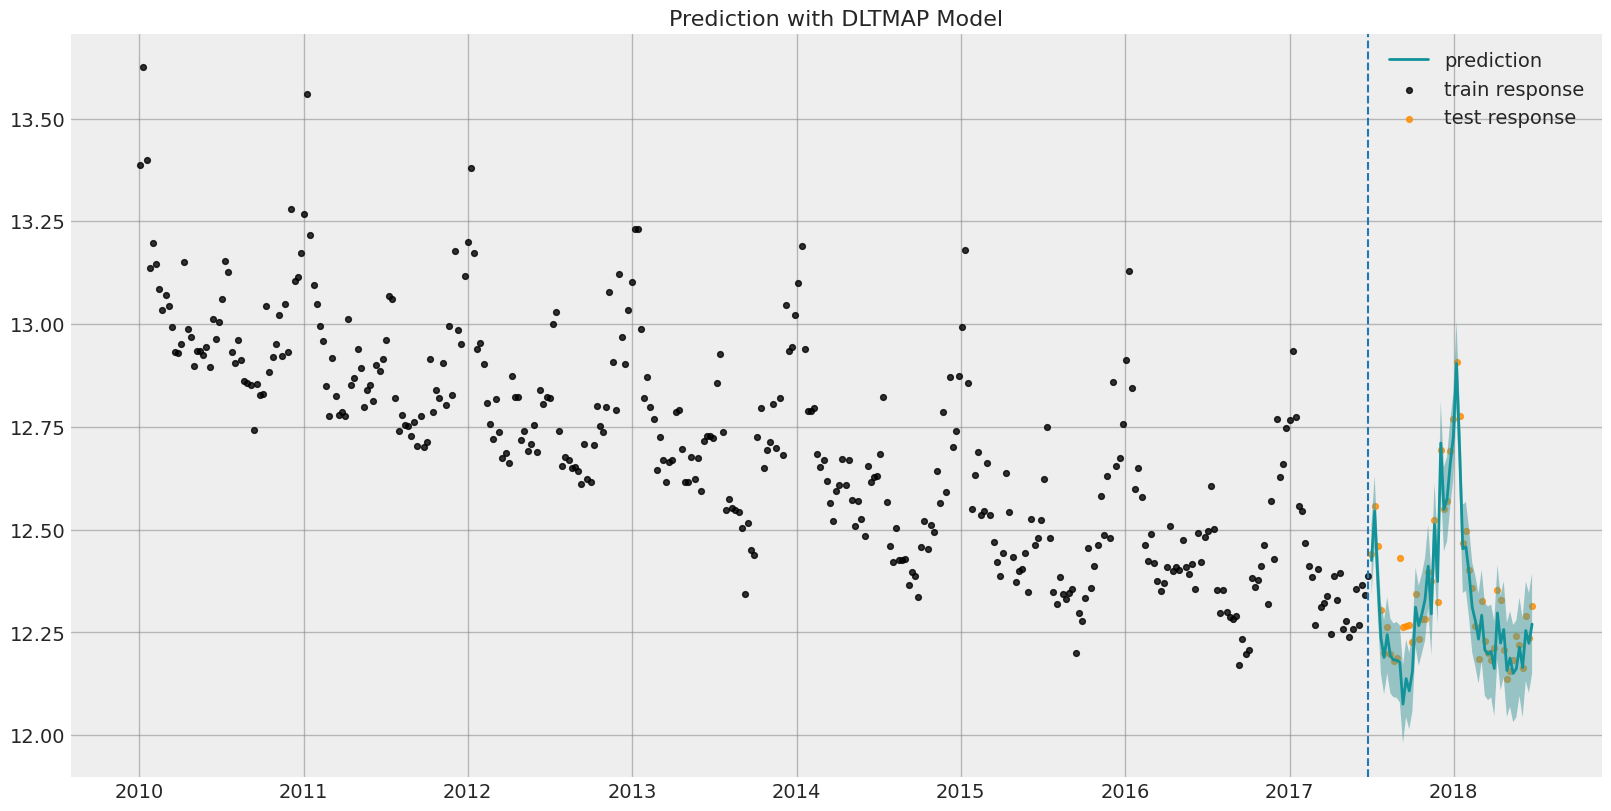

In [11]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                        title='Prediction with DLTMAP Model')

### DLTFull

LGT model for full prediction. In full prediction, the prediction occurs as a function of each parameter posterior sample, and the prediction results are aggregated after prediction. Prediction will always return the median (aka 50th percentile) along with any additional percentiles that are specified.

In [12]:
dlt = DLTFull(response_col=RESPONSE_COL,
              date_col=DATE_COL,
              seasonality=52,
              seed=8888)

In [13]:
dlt.fit(df=train_df)


Gradient evaluation took 0.000552 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.52 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)

Gradient evaluation took 0.000822 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.22 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.000858 seconds
Gradient evaluation took 0.00086 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.58 seconds.
1000 transitions using 10 leapfrog steps per transition would take 8.6 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!




Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iter

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 4.67338 seconds (Warm-up)
               0.176959 seconds (Sampling)
               4.85034 seconds (Total)



In [14]:
predicted_df = dlt.predict(df=test_df, store_prediction_array=True)

In [15]:
predicted_df.tail()

,week,prediction_5,prediction,prediction_95
47,2018-05-27,12.131934,12.230461,12.342687
48,2018-06-03,12.059667,12.178909,12.317250
49,2018-06-10,12.166105,12.270066,12.380907
50,2018-06-17,12.130973,12.242566,12.350058
51,2018-06-24,12.194247,12.277364,12.396784


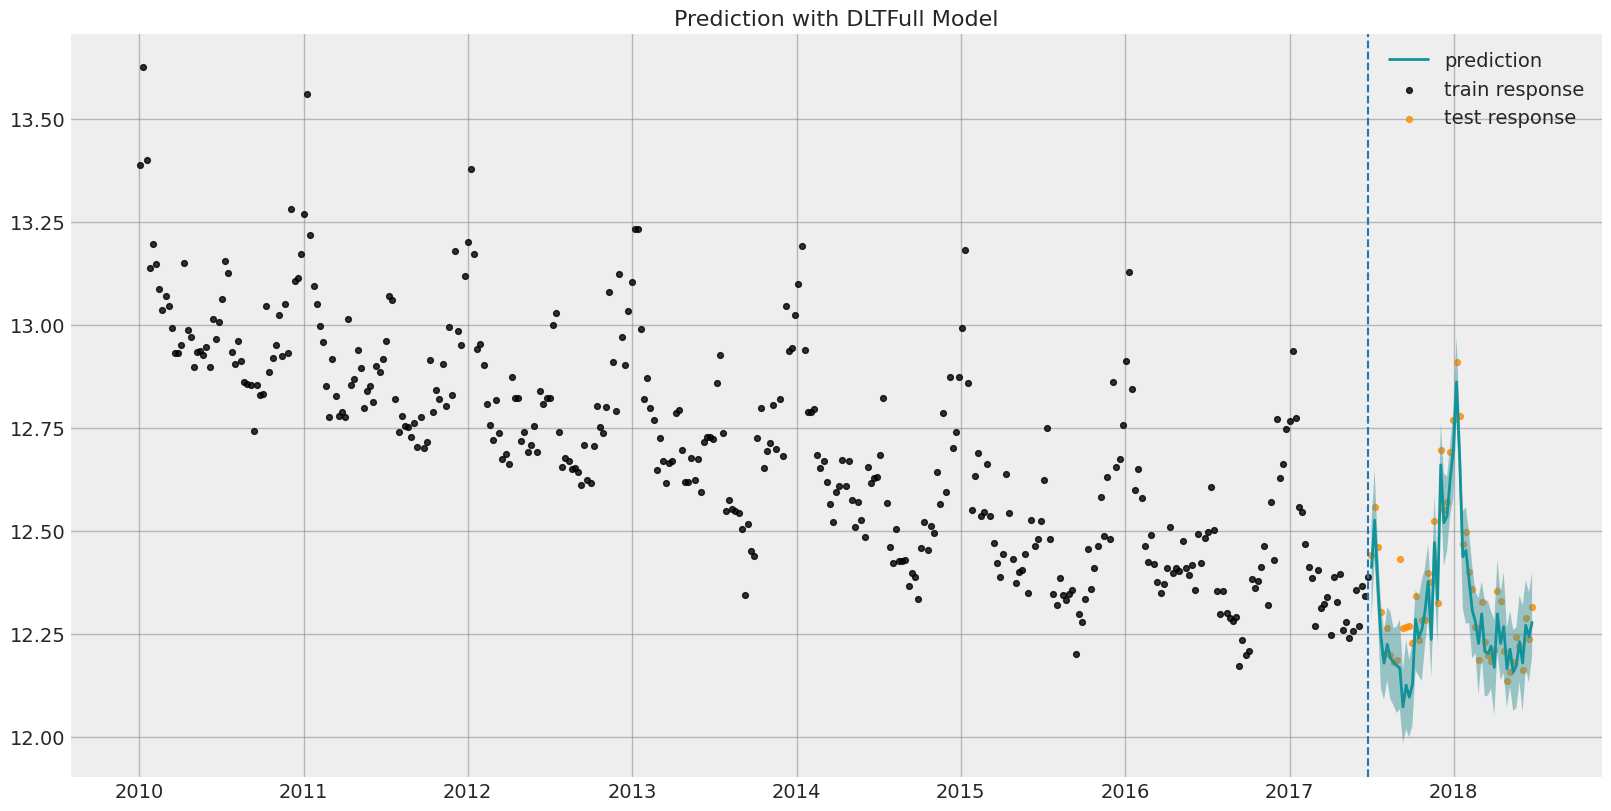

In [16]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                        title='Prediction with DLTFull Model')

### DLTAggregated

DLT model for aggregated posterior prediction. In aggregated prediction, the parameter posterior samples are reduced using `aggregate_method ({ 'mean', 'median' })` before performing a single prediction.

In [17]:
dlt = DLTAggregated(response_col=RESPONSE_COL,
                    date_col=DATE_COL,
                    seasonality=52,
                    seed=8888)

In [18]:
dlt.fit(df=train_df)



Gradient evaluation took 0.00054 seconds
Gradient evaluation took 0.00054 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.4 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 5.4 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)

Gradient evaluation took 0.000785 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.85 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000771 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.71 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iterat

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 4.72384 seconds (Warm-up)
               0.184818 seconds (Sampling)
               4.90866 seconds (Total)



In [19]:
predicted_df = dlt.predict(df=test_df)

In [20]:
predicted_df.tail()

,week,prediction_5,prediction,prediction_95
47,2018-05-27,12.128926,12.237519,12.346262
48,2018-06-03,12.065537,12.175224,12.284132
49,2018-06-10,12.158752,12.269020,12.378188
50,2018-06-17,12.125781,12.237546,12.347848
51,2018-06-24,12.174032,12.284472,12.394432


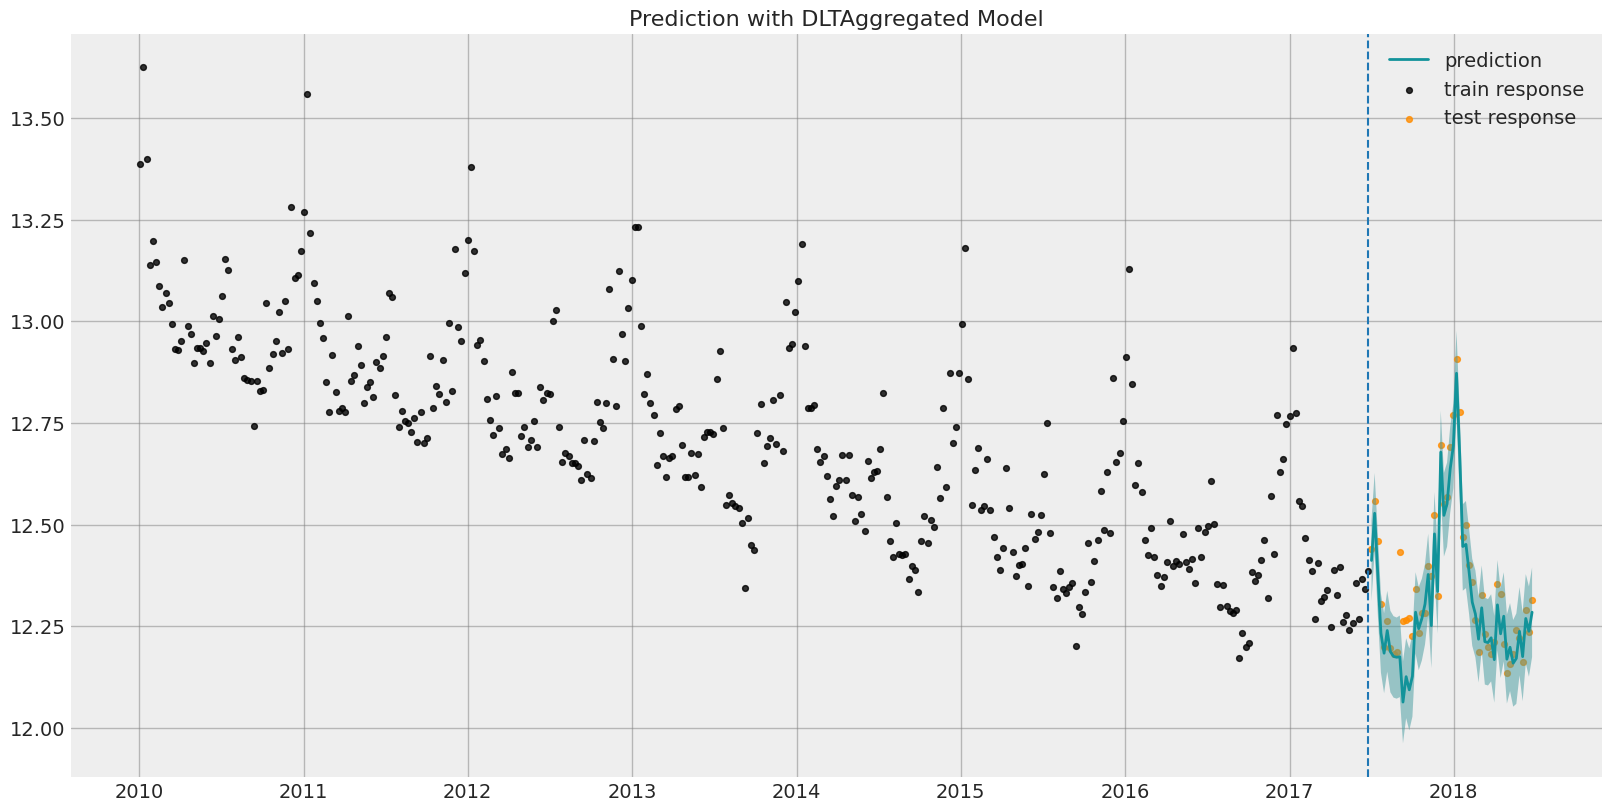

In [21]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                        title='Prediction with DLTAggregated Model')

## DLT Model with Global Trend

The main differences between `DLT` and `LGT` are mainly:

- It introduces a damped factor on local trend
- It models global trend as a determinstic projection

There are four options in modeling the `global trend` with the `global_trend_option` arguemnt:

1. `linear`
2. `loglinear`
3. `logistic`
4. `flat`

The behavior of these three options will depend on the condition of `is_multiplicative` as well.  Below, we only show cases with condition when `is_multiplicative` as `True` since it is the default.

### Data

Instead of splitting the data into train and test. We will use the full data set to train and simulate the multiplicative prediction data in the following 4 years.

In [22]:
num_periods = 52 * 4

freq = 7

last_dt = (df[date_col].dt.to_pydatetime())[-1]

dts = [last_dt + timedelta(days=x * freq) for x in range(1, num_periods + 1)]

future_df = pd.DataFrame(dts, columns=[date_col])

### Linear Trend

In multiplicative model, the linear trend as default will be transformed as exponential growth/decay.

In [23]:
dlt = DLTMAP(response_col=RESPONSE_COL,
             date_col=DATE_COL,
             seasonality=52,
             seed=8888)

In [24]:
dlt.fit(df)

Initial log joint probability = 70.4924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19        880.81     0.0592024        30.071           1           1       27   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       899.122      0.319881       32.9972           1           1       47   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       901.891     0.0265229       6.81999           1           1       67   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       902.284    0.00746347       5.37123      0.7036      0.7036       88   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       902.437     0.0413198       7.92478           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [25]:
predicted_df = dlt.predict(df=future_df, decompose=True)

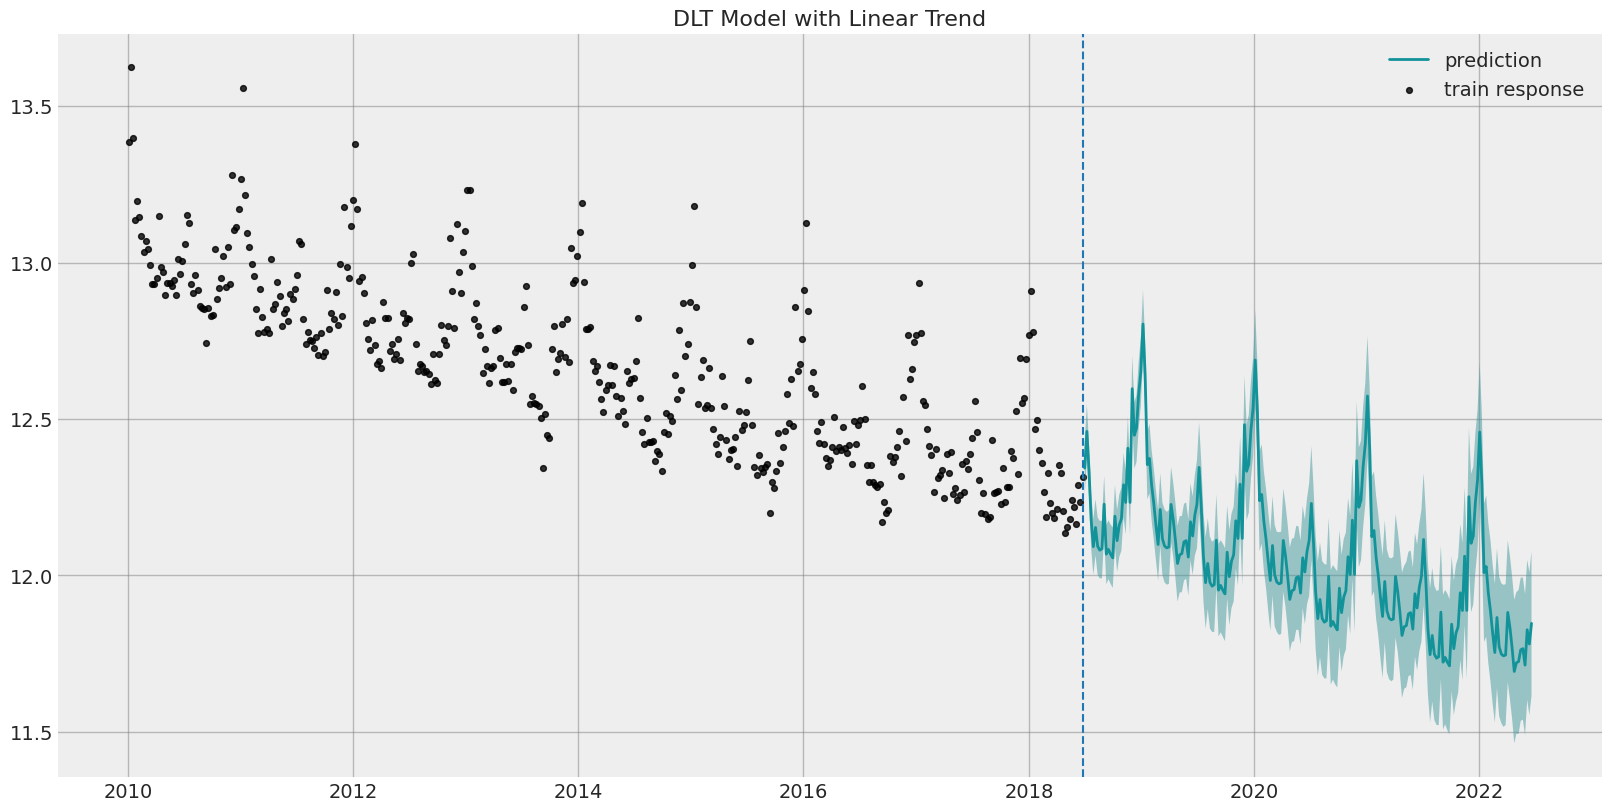

In [26]:
_ = plot_predicted_data(training_actual_df=df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        title='DLT Model with Linear Trend')

### Log-Linear Trend

For users who want to maintain linear trend assumption in the multiplicative model, they can switch to `loglinear` global trend.  

In [27]:
dlt_log = DLTMAP(response_col=RESPONSE_COL,
                 date_col=DATE_COL,
                 seasonality=52,
                 seed=8888,
                 global_trend_option='loglinear')

In [28]:
dlt_log.fit(df=df)

Initial log joint probability = 74.1119
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       872.159     0.0158864       42.4711      0.1289      0.1289       24   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39        887.08      0.347924       26.4501           1           1       48   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       892.676       1.08629       12.5062           1           1       70   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       894.802      0.216788       4.66471      0.7455      0.7455       91   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       894.887     0.0185374       1.19541      0.2565      0.6887      117   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [29]:
predicted_df_dlt_log = dlt_log.predict(df=future_df, decompose=True)

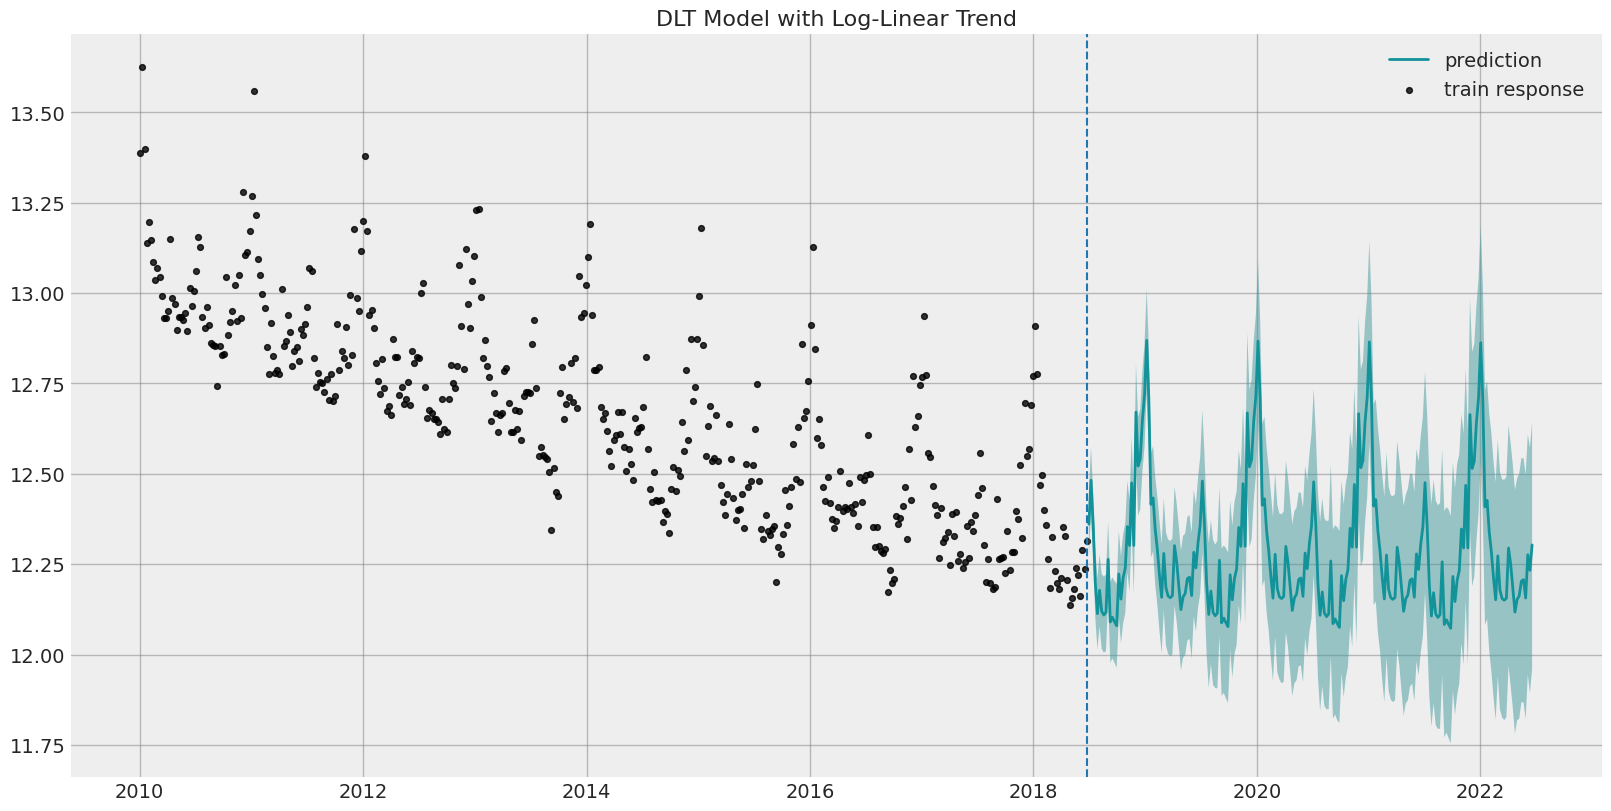

In [30]:
_ = plot_predicted_data(training_actual_df=df,
                        predicted_df=predicted_df_dlt_log, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        title='DLT Model with Log-Linear Trend')

### Logistic Trend

In case of modeling logistic growth/decay, user can switch to `logistic` in the `global_trend_option`. 

In [31]:
dlt_logit = DLTMAP(response_col=RESPONSE_COL,
                   date_col=DATE_COL,
                   seasonality=52,
                   seed=8888,
                   global_trend_option='logistic')

In [32]:
dlt_logit.fit(df=df)

Initial log joint probability = 71.399
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       868.646      0.202545       44.3283           1           1       25   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       889.675     0.0923697       33.7034      0.9785      0.9785       47   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       901.648     0.0530933       14.0135           1           1       69   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       902.413     0.0994414        19.409      0.2308           1       91   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       902.796    0.00726762       1.47614      0.3439           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha    

In [33]:
predicted_df_dlt_logit = dlt_logit.predict(df=future_df, decompose=True)

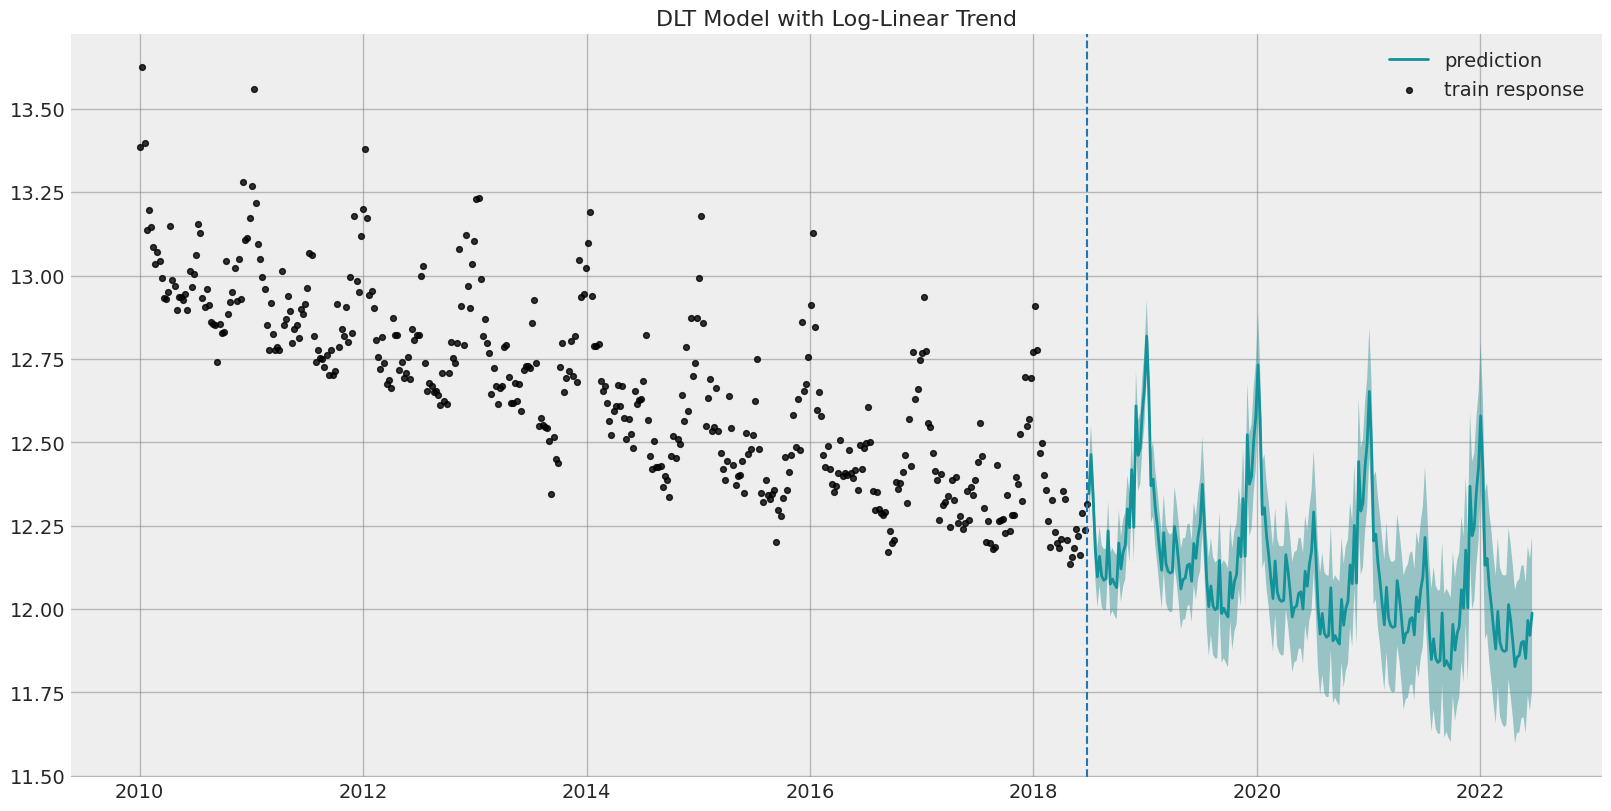

In [34]:
_ = plot_predicted_data(training_actual_df=df,
                        predicted_df=predicted_df_dlt_logit, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        title='DLT Model with Log-Linear Trend')

### Flat Trend

In [35]:
dlt_logit = DLTMAP(response_col=RESPONSE_COL,
                   date_col=DATE_COL,
                   seasonality=52,
                   seed=8888,
                   global_trend_option='flat')

In [36]:
dlt_logit.fit(df=df)

Initial log joint probability = 71.9048
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       869.838     0.0170874       39.0782      0.1424      0.1424       24   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       885.378      0.536308       19.5572      0.3763           1       46   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59        890.61     0.0916862       8.29938      0.6474      0.6474       70   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       891.271      0.144757       3.46798           1           1       93   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       891.322     0.0669503       1.47286           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [37]:
predicted_df_dlt_logit = dlt_logit.predict(df=future_df, decompose=True)

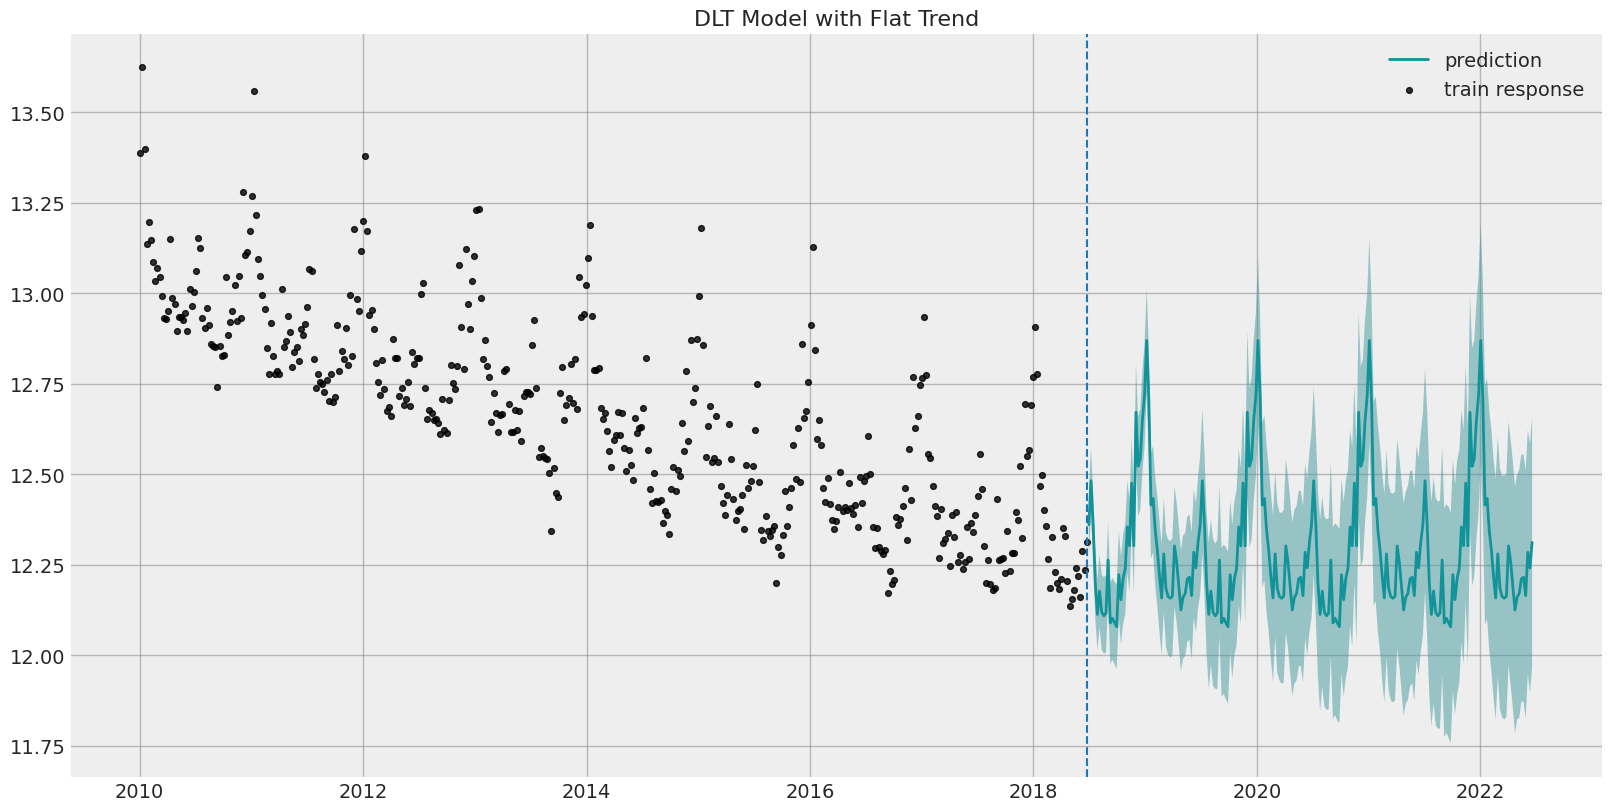

In [38]:
_ = plot_predicted_data(training_actual_df=df,
                        predicted_df=predicted_df_dlt_logit, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        title='DLT Model with Flat Trend')

More details for each method are available in the docstrings and also here: https://orbit-ml.readthedocs.io/en/latest/orbit.models.html#module-orbit.models.dlt